In [8]:
# VGG 13 Architecture Bonus

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

food_dir = '/kaggle/input/cnn-data/food/'
dogs_dir = '/kaggle/input/cnn-data/dogs/'
vehicles_dir = '/kaggle/input/cnn-data/vehicles/'

# Loading the images from the directories
food_images = [cv2.resize(cv2.imread(os.path.join(food_dir, file)), (227, 227)) for file in os.listdir(food_dir)]
dog_images = [cv2.resize(cv2.imread(os.path.join(dogs_dir, file)), (227, 227)) for file in os.listdir(dogs_dir)]
vehicle_images = [cv2.resize(cv2.imread(os.path.join(vehicles_dir, file)), (227, 227)) for file in os.listdir(vehicles_dir)]

# Concatenate the images
X = np.concatenate((food_images, dog_images, vehicle_images), axis=0)
y = np.concatenate((np.zeros(len(food_images)), np.ones(len(dog_images)), np.ones(len(vehicle_images))*2), axis=0)
num_classes = len(np.unique(y))

# Shuffling the dataset
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

# Splitting the dataset into training, validation, and testing sets
train_size = int(0.7 * X.shape[0])
val_size = int(0.2 * X.shape[0])
test_size = X.shape[0] - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[-test_size:]
y_test = y[-test_size:]


batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

# Define the model
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(227,227,3)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=1000, activation='softmax')
])

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = keras.optimizers.Adam(learning_rate=0.005)

# Define the training loop
history = []
epochs = 10
for epoch in range(epochs):
    print('Epoch %d/%d' % (epoch+1, epochs))
    
    train_loss = 0
    train_acc = 0
    train_steps = 0
    for x_batch_train, y_batch_train in train_dataset:
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        train_loss += loss_value.numpy()
        y_pred = np.argmax(logits.numpy(), axis=1)
        train_acc += np.mean(y_batch_train.numpy() == y_pred)
        train_steps += 1
    train_loss /= train_steps
    train_acc /= train_steps
    
    # Evaluating the model on the validation dataset
    val_loss = 0
    val_acc = 0
    val_steps = 0
    for x_batch_val, y_batch_val in val_dataset:
        logits = model(x_batch_val, training=False)
        loss_value = loss_fn(y_batch_val, logits)
        
        val_loss += loss_value.numpy()
        y_pred = np.argmax(logits.numpy(), axis=1)
        val_acc += np.mean(y_batch_val.numpy() == y_pred)
        val_steps += 1
    val_loss /= val_steps
    val_acc /= val_steps
    history.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
    # Print the training and validation loss and accuracy
    print('Train Loss: %.4f' % train_loss)
    print('Train Accuracy: %.4f' % train_acc)
    print('Val Loss: %.4f' % val_loss)
    print('Val Accuracy: %.4f' % val_acc)

# Evaluating the model on the testing dataset
test_loss = 0
test_acc = 0
test_steps = 0
for x_batch_test, y_batch_test in test_dataset:
    logits = model(x_batch_test, training=False)
    loss_value = loss_fn(y_batch_test, logits)

    test_loss += loss_value.numpy()
    y_pred = np.argmax(logits.numpy(), axis=1)
    test_acc += np.mean(y_batch_test.numpy() == y_pred)
    test_steps += 1
test_loss /= test_steps
test_acc /= test_steps

# Print the testing loss and accuracy
print('\n Test Loss: %.4f' % test_loss)
print('Test Accuracy: %.4f' % test_acc)

In [13]:
print(history)

[{'epoch': 1, 'train_loss': 5.532361071929335, 'train_acc': 0.4596354166666667, 'val_loss': 344.0343297322591, 'val_acc': 0.3255208333333333}, {'epoch': 2, 'train_loss': 2.0156439736485483, 'train_acc': 0.4697916666666667, 'val_loss': 95.22116406758626, 'val_acc': 0.3255208333333333}, {'epoch': 3, 'train_loss': 1.876234169304371, 'train_acc': 0.5515625, 'val_loss': 44.45747820536295, 'val_acc': 0.328125}, {'epoch': 4, 'train_loss': 2.056327310204506, 'train_acc': 0.5606770833333333, 'val_loss': 11.340362429618835, 'val_acc': 0.4192708333333333}, {'epoch': 5, 'train_loss': 2.2253110229969026, 'train_acc': 0.6049479166666667, 'val_loss': 3.387187659740448, 'val_acc': 0.5703125}, {'epoch': 6, 'train_loss': 1.760478749871254, 'train_acc': 0.6557291666666667, 'val_loss': 6.86689571539561, 'val_acc': 0.4817708333333333}, {'epoch': 7, 'train_loss': 1.5515117041766644, 'train_acc': 0.6145833333333333, 'val_loss': 13.128130992253622, 'val_acc': 0.5572916666666666}, {'epoch': 8, 'train_loss': 1.

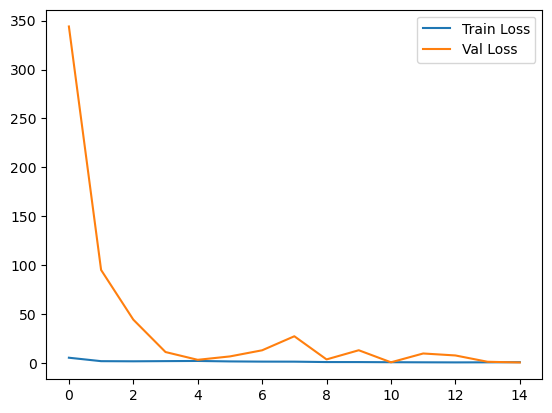

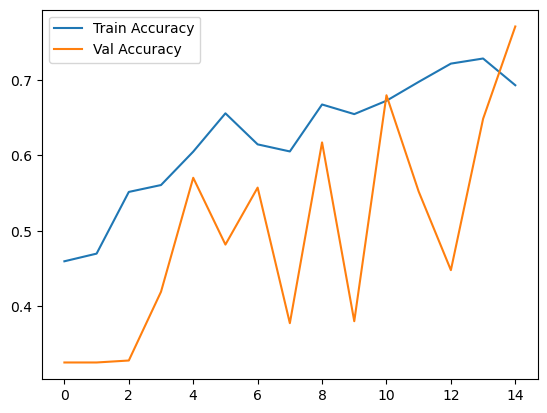

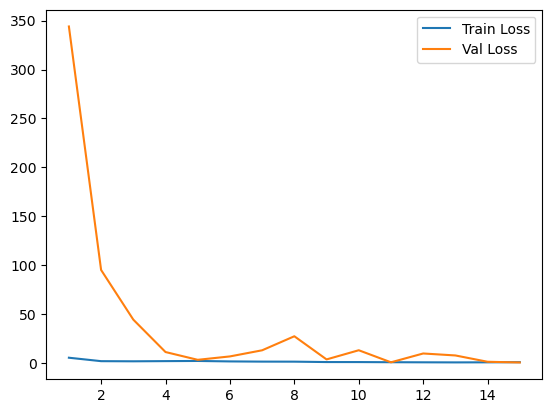

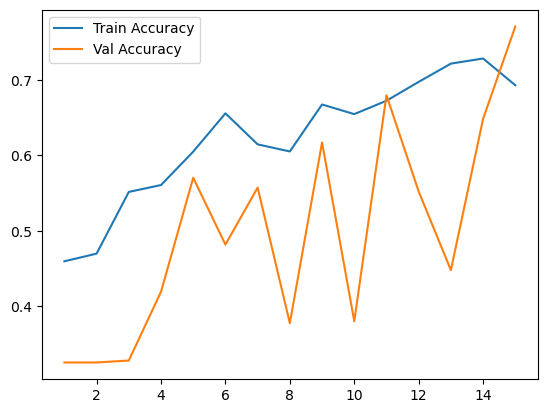

In [17]:
# Plot the training and validation loss and accuracy

plt.plot([h['epoch'] for h in history ],[ h['train_loss'] for h in history ], label='Train Loss')
plt.plot([h['epoch'] for h in history], [h['val_loss'] for h in history], label='Val Loss')
plt.legend()
plt.show()
plt.plot([h['epoch'] for h in history], [h['train_acc'] for h in history], label='Train Accuracy')
plt.plot([h['epoch'] for h in history], [ h['val_acc'] for h in history ], label='Val Accuracy')
plt.legend()
plt.show()

### References
1. https://medium.com/prathmesh-bhansali/exploring-svhn-using-deep-neural-network-1213959db92c
2. https://www.tensorflow.org/tutorials/load_data/images
3. https://www.tensorflow.org/tutorials/images/classification
4. https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
5. https://www.tensorflow.org/
6. https://keras.io/